# Comparison between real dataset and simulation dataset by edit distance

Metrics: edit distance [1]  
Dataset: CASAS Aruba dataset (http://casas.wsu.edu/datasets/) [2], Kasteren dataset [3] 

References
- [1] S. Kristiansen, T. P. Plagemann and V. Goebel, "An activity rule based approach to simulate adl sequences." IEEE Access, 6(2018), 12551–12572.
- [2] D. Cook et al., "CASAS: A Smart Home in a Box." IEEE Computer, 46-7(2013), 62-69.
- [3]  T. Van Kasteren et al., "Accurate activity recognition in a home setting." Proc. of the 10th international conference on Ubiquitous computing (UbiComp 2008), 1–9.

# Import libraries

In [2]:
import datetime
import itertools
import time
from pathlib import Path
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# self-made
import src.activity_model as activity_model
import src.analysis as analysis
import src.anomaly_model as anomaly_model
import src.comparison as comparison

import src.utils as utils
import src.sensor_model as sensor_model

working_path = Path().resolve()
layout_data_path = working_path / "layout_data"

# Aruba dataset

In [3]:
Aruba_path = Path("./aruba/data")
Aruba = comparison.load_CASAS_Aruba(
    Aruba_path
)  # some modifications were applied to original data (check comparison.load_CASAS_Aruba)
Aruba_days = comparison.convert_data_into_days(
    Aruba
)  # List of divided activity sequences for each day.

activity_names = []
for a in Aruba:
    if a[0] not in activity_names:
        activity_names.append(a[0])
print(activity_names)
day = 0
print("{} day activity sequence of Aruba dataset".format(day))
for x in Aruba_days[day]:
    print("{}  ({} - {})".format(x[0], x[1].start, x[1].end))

['Sleeping', 'Meal_Preparation', 'Other', 'Relax', 'Housekeeping', 'Take_Breakfast', 'Wash_Dishes', 'Take_Lunch', 'Work', 'Take_Dinner', 'Go_out', 'Nap']
0 day activity sequence of Aruba dataset
Sleeping  (0:00:00 - 8:11:09.966157)
Meal_Preparation  (8:11:09.966157 - 8:35:45.822482)
Other  (8:35:45.822482 - 9:29:23.223133)
Relax  (9:29:23.223133 - 9:34:16.851472)
Housekeeping  (9:34:16.851472 - 9:48:52.342223)
Meal_Preparation  (9:48:52.342223 - 9:56:41.831135)
Take_Breakfast  (9:56:41.831135 - 10:03:21.966597)
Wash_Dishes  (10:03:21.966597 - 10:04:25.772378)
Other  (10:04:25.772378 - 11:29:08.108298)
Housekeeping  (11:29:08.108298 - 11:47:52.575602)
Other  (11:47:52.575602 - 14:46:25.648668)
Relax  (14:46:25.648668 - 15:23:00.012287)
Meal_Preparation  (15:23:00.012287 - 15:25:35.233346)
Take_Lunch  (15:25:35.233346 - 15:28:42.550415)
Other  (15:28:42.550415 - 15:47:48.178484)
Work  (15:47:48.178484 - 16:15:57.476492)
Relax  (16:15:57.476492 - 16:21:59.792013)
Meal_Preparation  (16:21:

### Check frequencies of activities on time of day of Aruba dataset

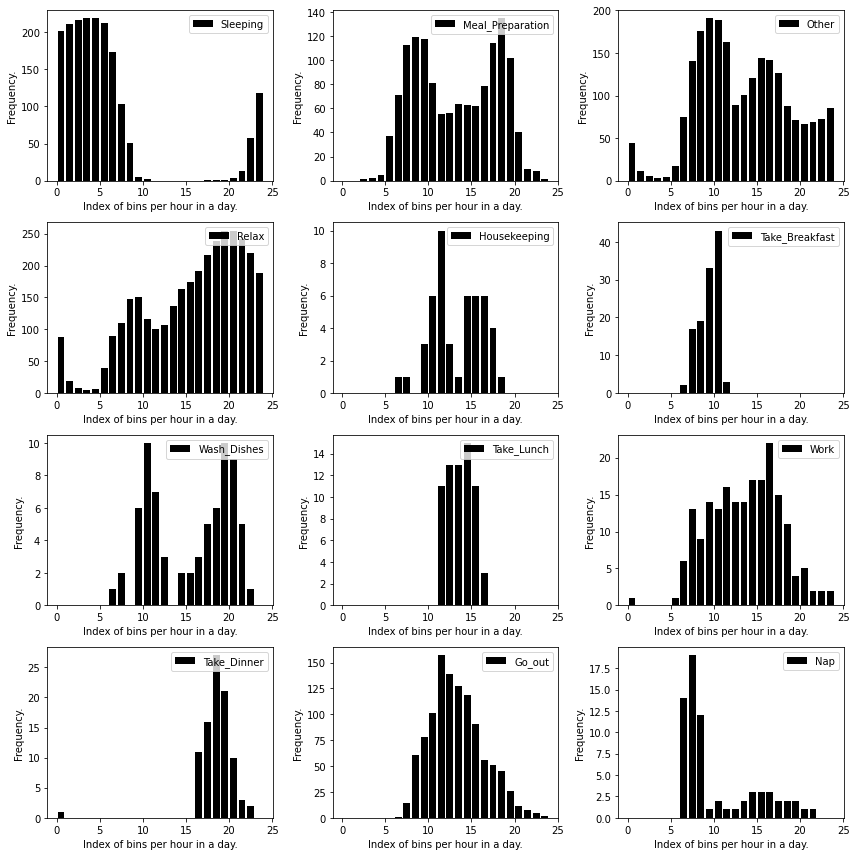

In [8]:
# In the following, it creates a histogram for each action.
# The horizontal axis represents a time interval in which a day is divided into equal time intervals.
# The vertical axis shows the number of times the activity was performed in the time interval in the data.
# count multiple time if multiple same activities are done in the time interval
# e.g., ..., ('TV', 13[h]04[m], 13[h]13[m]), ('Work', 13[h]13[m], 13[h]24[m]),
#            ('TV', 13[h]24[m], 13[h]45[m]), ('Eating', 13[h]45[m], 14[h]55[m]),
#            ('TV', 13[h]55[m], 14[h]25[m]), ...
# time interval (13:00 - 14:00) counts TV 3 times

# Load Aruba dataset
Aruba_path = Path("./aruba/data")
Aruba = comparison.load_CASAS_Aruba(
    Aruba_path
)  # some modifications were applied to original data (check comparison.load_CASAS_Aruba)
activity_names = []
for a in Aruba:
    if a[0] not in activity_names:
        activity_names.append(a[0])

temp_dict = {a: None for a in activity_names}
interval_len = timedelta(hours=1)  # must be less than 24 [h]
step_len = interval_len / timedelta(hours=24)
t_list = list(
    utils.date_generator(timedelta(hours=0), timedelta(hours=24), step=interval_len)
)
plot_x = [24 * i * step_len for i in range(len(t_list))]
plot_x = [x + 24 * step_len / 2 for x in plot_x]

for activity_name in activity_names:
    plot_y = [0 for i in t_list]
    for i, t in enumerate(t_list):
        interval = utils.TimeInterval(t, t + interval_len)
        for day in Aruba_days:
            for a in day:
                if a[0] == activity_name and a[1].overlap(interval) == True:
                    plot_y[i] += 1
    temp_dict[activity_name] = plot_y

fig = plt.figure(figsize=(12, 12))
axs = [fig.add_subplot(4, 3, i) for i in range(1, 13)]
for i, a in enumerate(activity_names):
    axs[i].set_xlabel("Index of bins per hour in a day.")
    axs[i].set_ylabel("Frequency.")
    axs[i].bar(plot_x, temp_dict[a], label=a, color="black")
    axs[i].legend(loc="upper right")
fig.tight_layout()
plt.show()
plt.close()

### Check daily frequencies of activities histogram per day of Aruba dataset

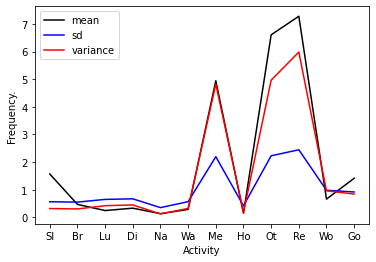

In [14]:
# Load Aruba dataset
Aruba_path = Path("./aruba/data")
Aruba = comparison.load_CASAS_Aruba(
    Aruba_path
)  # some modifications were applied to original data (check comparison.load_CASAS_Aruba)
activity_names = []
for a in Aruba:
    if a[0] not in activity_names:
        activity_names.append(a[0])

freq_mean, freq_sd = comparison.estimate_daily_frequency(Aruba, activity_names)
plot_mean = [freq_mean[a] for a in activity_names]
plot_sd = [freq_sd[a] for a in activity_names]
plot_var = [x**2 for x in plot_sd]
plot_x = []
for n in activity_names:  # Abbreaviation of activities to plot
    if n == "Take_Breakfast":
        plot_x.append("Br")
    elif n == "Take_Lunch":
        plot_x.append("Lu")
    elif n == "Take_Dinner":
        plot_x.append("Di")
    else:
        plot_x.append(n[:2])

order = [0, 5, 7, 9, 11, 6, 1, 4, 2, 3, 8, 10]
plt.plot(
    [plot_x[i] for i in order], [plot_mean[i] for i in order], c="black", label="mean"
)
plt.plot([plot_x[i] for i in order], [plot_sd[i] for i in order], c="blue", label="sd")
plt.plot(
    [plot_x[i] for i in order], [plot_var[i] for i in order], c="r", label="variance"
)
plt.xlabel("Activity")
plt.ylabel("Frequency.")
plt.legend()
plt.show()
plt.close()

### Statistics of activities in Aruba dataset

Mean start time [hour]: {'Sleeping': 23.792797357000797, 'Take_Breakfast': 9.280758422589825, 'Take_Lunch': 13.444986567168272, 'Take_Dinner': 18.564566220217355}
SD of start time [hour]: {'Sleeping': 1.3825254504899922, 'Take_Breakfast': 1.1465514153031076, 'Take_Lunch': 1.4252454747165457, 'Take_Dinner': 1.462992412473863}
Mean duration time [hour]: {'Sleeping': 6.93457506270895, 'Meal_Preparation': 0.23188109775888477, 'Other': 0.5547298321651979, 'Relax': 1.1372480772231384, 'Housekeeping': 0.4111565623569024, 'Take_Breakfast': 0.1549435418257821, 'Wash_Dishes': 0.14677699736331573, 'Take_Lunch': 0.24759013636831273, 'Work': 0.38633866104938275, 'Take_Dinner': 0.2566882673287672, 'Go_out': 2.4235968311950713, 'Nap': 1.611899301599617}
SD of start time [hour]: {'Sleeping': 1.780218623323245, 'Meal_Preparation': 0.22684304752596204, 'Other': 0.7120286858572163, 'Relax': 1.220544446288422, 'Housekeeping': 0.3761353963129972, 'Take_Breakfast': 0.13864943773542748, 'Wash_Dishes': 0.1427

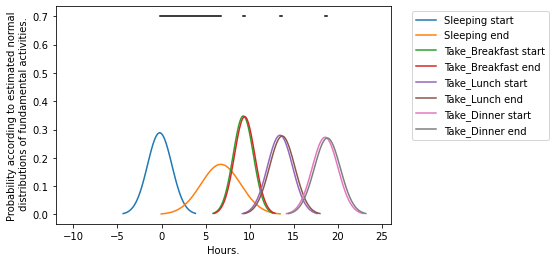

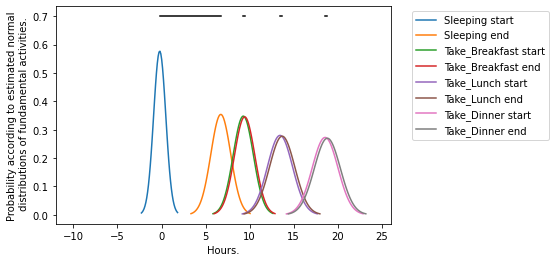

In [5]:
Aruba_path = Path("./aruba/data")
Aruba = comparison.load_CASAS_Aruba(
    Aruba_path
)  # some modification was applied (check comparison.load_CASAS_Aruba)
activity_names = []
for a in Aruba:
    if a[0] not in activity_names:
        activity_names.append(a[0])

# learn the fundamental parameters
fundamental_act_names = ["Sleeping", "Take_Breakfast", "Take_Lunch", "Take_Dinner"]
start_hour_mean, start_hour_sd = comparison.estimate_start_time(
    Aruba, fundamental_act_names
)
duration_hour_mean, duration_hour_sd = comparison.estimate_duration_time(
    Aruba, activity_names
)
freq_mean, freq_sd = comparison.estimate_daily_frequency(Aruba, activity_names)

print("Mean start time [hour]: {}".format(start_hour_mean))
print("SD of start time [hour]: {}".format(start_hour_sd))
print("Mean duration time [hour]: {}".format(duration_hour_mean))
print("SD of start time [hour]: {}".format(duration_hour_sd))
print("Mean daily frequency [times/day]: {}".format(freq_mean))
print("SD of daily frequency [times/day]: {}".format(freq_sd))

# It estimates normal distributions of start time and end_time of each fundamental activity.
for a in fundamental_act_names:
    mu_s, sigma_s = start_hour_mean[a], start_hour_sd[a]
    if a == "Sleeping" and mu_s > 12:
        mu_s -= 24
    mu_d, sigma_d = duration_hour_mean[a], duration_hour_sd[a]
    X_s = np.arange(mu_s - 3 * sigma_s, mu_s + 3 * sigma_s, 0.1)
    Y_s = stats.norm.pdf(X_s, mu_s, sigma_s)
    mu_e, sigma_e = mu_s + mu_d, np.sqrt(sigma_s**2 + sigma_d**2)
    X_e = np.arange(mu_e - 3 * sigma_e, mu_e + 3 * sigma_e, 0.1)
    Y_e = stats.norm.pdf(X_e, mu_e, sigma_e)
    plt.plot(X_s, Y_s, label=a + " start")  # start time
    plt.plot(X_e, Y_e, label=a + " end")  # end time
    plt.plot([mu_s, mu_e], [0.7, 0.7], c="k")
plt.xlim(-12, 26)
plt.xlabel("Hours.")
plt.ylabel(
    "Probability according to estimated normal\n distributions of fundamental activities."
)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()
plt.close()


### Modification of sleeping parameters to avoid overlap between 'Sleeping' and 'Take_Breakast'
start_hour_sd["Sleeping"] = start_hour_sd["Sleeping"] / 2
duration_hour_sd["Sleeping"] = duration_hour_sd["Sleeping"] / 2

# It estimates normal distributions of start time and end_time of each fundamental activity.
for a in fundamental_act_names:
    mu_s, sigma_s = start_hour_mean[a], start_hour_sd[a]
    if a == "Sleeping" and mu_s > 12:
        mu_s -= 24
    mu_d, sigma_d = duration_hour_mean[a], duration_hour_sd[a]
    X_s = np.arange(mu_s - 3 * sigma_s, mu_s + 3 * sigma_s, 0.1)
    Y_s = stats.norm.pdf(X_s, mu_s, sigma_s)
    mu_e, sigma_e = mu_s + mu_d, np.sqrt(sigma_s**2 + sigma_d**2)
    X_e = np.arange(mu_e - 3 * sigma_e, mu_e + 3 * sigma_e, 0.1)
    Y_e = stats.norm.pdf(X_e, mu_e, sigma_e)
    plt.plot(X_s, Y_s, label=a + " start")  # start time
    plt.plot(X_e, Y_e, label=a + " end")  # end time
    plt.plot([mu_s, mu_e], [0.7, 0.7], c="k")
plt.xlim(-12, 26)
plt.xlabel("Hours.")
plt.ylabel(
    "Probability according to estimated normal\n distributions of fundamental activities."
)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()
plt.close()

## Calculate edit distance between converted activity sequences.

Daily activity sequences are converted into string divided by a unit time duration. All pairs of converted sequence was calculated.  
Suppose data1 includes M days and data2 includes N days.  
Same days distance (rho(data)) means a mean distance of all 2-combinations of {1, 2, ..., N}.  
Different days distance (rho(data1, data2)) means a mean distance of elements of Cartesian product {1, 2, ..., M} * {1, 2, ..., N}.  
delta_intra(data) = | rho(data) - rho(Aruba_test) |.  
delta_inter(data) = | rho(data, Aruba_test) - rho(Aruba_test) |.  
The operation | a | means the absolute value of a.  

In [7]:
Aruba_path = Path("./aruba/data")
Aruba = comparison.load_CASAS_Aruba(
    Aruba_path
)  # some modification was applied (check comparison.load_CASAS_Aruba)
Aruba_days = comparison.convert_data_into_days(
    Aruba
)  # List of divided activity sequences for each day.
activity_names = []
for a in Aruba:
    if a[0] not in activity_names:
        activity_names.append(a[0])

test_data_1 = Aruba_days[:20]
test_data_2 = Aruba_days[20:40]
l = comparison.same_days_distance(test_data_1, timedelta(minutes=1))
print("Same days distance: {}".format(l))
n = int(2 * len(Aruba_days) / 3)
l_d = comparison.different_days_distance(test_data_1, test_data_2, timedelta(minutes=1))
print("Different days distance: {}".format(l))

converting days into strings, 100% completed!
calculate distances, 100% completed!
Same days distance: (637.2421052631579, 125.19124030138629)
converting days of Xday into strings, 100% completed!
converting days of Yday into strings, 100% completed!
calculate distances, 100% completed!
Different days distance: (637.2421052631579, 125.19124030138629)


## Generate some datasets for comparison

In [2]:
# modify_sleep_param determines
# whether to shrink (1) the standard deviation of start time of 'Sleeping' and,
#                   (2) the standard deviation of duration time of 'Sleeping'
# to avoid overlap between 'Sleeping' and 'Take_Breakast'.
modify_sleep_param = True

path = Path(layout_data_path / "test_layout")
# This 'path' does not affect simulated data, but needs to use the function generate_activity_sequence.

# Aruba dataset
Aruba_path = Path("./aruba/data")
Aruba = comparison.load_CASAS_Aruba(Aruba_path)
Aruba_days = comparison.convert_data_into_days(Aruba)
activity_names = []
for a in Aruba:
    if a[0] not in activity_names:
        activity_names.append(a[0])

n_t = int(2 * len(Aruba_days) / 3)
Aruba_train = Aruba_days[:n_t]  # Aruba_train is used for parameter estimating.
Aruba_test = Aruba_days[n_t:]
Aruba_n_t = []
for a in Aruba:
    if a[1].end.days < n_t:
        Aruba_n_t.append(a)
    else:
        last_act = (a[0], utils.TimeInterval(a[1].start, timedelta(days=n_t)))
        Aruba_n_t.append(last_act)
        break

start_day, end_day = 0, len(Aruba_days) - n_t - 1
Aruba_act_model = comparison.Aruba_activity_model(
    n_day=n_t, modify_sleep_param=modify_sleep_param
)
Aruba_act_model_sleep_only = comparison.Aruba_activity_model_sleep_only(n_day=n_t)
duration_hour_mean, duration_hour_sd = comparison.estimate_duration_time(
    Aruba_n_t, activity_names
)
mean_list = [
    timedelta(hours=duration_hour_mean[a]) / timedelta(minutes=1)
    for a in activity_names
]
sd_list = [
    timedelta(hours=duration_hour_sd[a]) / timedelta(minutes=1) for a in activity_names
]

# Simulation of each dataset is repeated 'N' times.
N = 10
N_days_Aruba_train = []
N_days_Aruba_test = []
N_days_simulation = []
N_days_RD = []  # random duration and random order (RD)
N_days_RS = []  # random duration except for sleep (RS)

for i in range(N):
    # All elements in N_days_Aruba_train (N_days_Aruba_test) are same. This is redundancy, but has uniformity compared to other N_days data.
    N_days_Aruba_train.append(Aruba_train)
    N_days_Aruba_test.append(Aruba_test)

    simulation = utils.generate_activity_sequence(
        start_day, end_day, path, original_act_model=Aruba_act_model
    )
    # change the format of the activity sequence.
    for i, a in enumerate(simulation):
        simulation[i] = (a.activity.name, utils.TimeInterval(a.start, a.end))
    N_days_simulation.append(comparison.convert_data_into_days(simulation))

    random_data = comparison.generate_random_activity_sequence(
        start_day, end_day, activity_names, mean_list, sd_list
    )
    N_days_RD.append(comparison.convert_data_into_days(random_data))

    random_with_fixed_sleep = utils.generate_activity_sequence(
        start_day, end_day, path, original_act_model=Aruba_act_model_sleep_only
    )
    for i, a in enumerate(random_with_fixed_sleep):
        random_with_fixed_sleep[i] = (
            a.activity.name,
            utils.TimeInterval(a.start, a.end),
        )
    N_days_RS.append(comparison.convert_data_into_days(random_with_fixed_sleep))

### Compare some datasets by edit distance

#### rho(Aruba_train), rho(Aruba_test), rho(Aruba_train, Aruba_test)

In [3]:
time_duration = timedelta(
    seconds=30
)  # Unit time interval that is converted into one character.
rho_Aruba_train = comparison.same_days_distance(Aruba_train, time_duration)
print("rho(Aruba_train): {}.".format(rho_Aruba_train))
rho_Aruba_test = comparison.same_days_distance(Aruba_test, time_duration)
print("rho(Aruba_test): {}.".format(rho_Aruba_test))
rho_Aruba_train_Aruba_test = comparison.different_days_distance(
    Aruba_train, Aruba_test, time_duration
)
print("rho(Aruba_train, Aruba_test): {}.".format(rho_Aruba_train_Aruba_test))

converting days into strings, 100% completed!
calculate distances, 100% completed!
rho(Aruba_train): (1264.0771846953235, 276.79500180135307).
converting days into strings, 100% completed!
calculate distances, 100% completed!
rho(Aruba_test): (1281.8544983339505, 267.66364740908256).
converting days of Xday into strings, 100% completed!
converting days of Yday into strings, 100% completed!
calculate distances, 100% completed!
rho(Aruba_train, Aruba_test): (1329.98454276194, 273.05039189521085).


#### rho(simulation), rho(RD), rho(RS)

In [4]:
time_duration = timedelta(seconds=30)

mean_list_S, _ = comparison.mean_same_days_distance(
    N_days_simulation, time_duration, print_progress=False
)
print(
    "rho(simulation): {} (± {}).".format(
        np.mean(mean_list_S), np.sqrt(np.var(mean_list_S))
    )
)

mean_list_RD, _ = comparison.mean_same_days_distance(
    N_days_RD, time_duration, print_progress=False
)
print(
    "rho(RD): {} (± {}).".format(np.mean(mean_list_RD), np.sqrt(np.var(mean_list_RD)))
)

mean_list_RS, _ = comparison.mean_same_days_distance(
    N_days_RS, time_duration, print_progress=False
)
print(
    "rho(RS): {} (± {}).".format(np.mean(mean_list_RS), np.sqrt(np.var(mean_list_RS)))
)

rho(simulation): 1309.9208811551277 (± 19.63426049466278).
rho(RD): 1961.1961495742319 (± 58.69390012737198).
rho(RS): 1801.8695298037765 (± 24.454647409949025).


#### delta_intra(simulation), delta_intra(RD), delta_intra(RS), using above cells.

In [6]:
delta_intra_S = np.array(mean_list_S) - rho_Aruba_test[0]
print(
    "delta_intra(simulation): {} (± {}).".format(
        np.mean(delta_intra_S), np.sqrt(np.var(delta_intra_S))
    )
)

delta_intra_RD = np.array(mean_list_RD) - rho_Aruba_test[0]
print(
    "delta_intra(RD): {} (± {}).".format(
        np.mean(delta_intra_RD), np.sqrt(np.var(delta_intra_RD))
    )
)

delta_intra_RS = np.array(mean_list_RS) - rho_Aruba_test[0]
print(
    "delta_intra(RS): {} (± {}).".format(
        np.mean(delta_intra_RS), np.sqrt(np.var(delta_intra_RS))
    )
)

delta_intra(simulation): 28.066382821177264 (± 19.63426049466278).
delta_intra(RD): 679.3416512402813 (± 58.69390012737198).
delta_intra(RS): 520.015031469826 (± 24.454647409949025).


#### rho(simulation, Aruba_test), rho(RD, Aruba_test), rho(RS, Aruba_test)

In [7]:
time_duration = timedelta(seconds=30)
mean_list_S_AT, _ = comparison.mean_different_days_distance(
    N_days_simulation, N_days_Aruba_test, time_duration, print_progress=False
)
print(
    "rho(simulation, Aruba_test): {} (± {}).".format(
        np.mean(mean_list_S_AT), np.sqrt(np.var(mean_list_S_AT))
    )
)

mean_list_RD_AT, _ = comparison.mean_different_days_distance(
    N_days_RD, N_days_Aruba_test, time_duration, print_progress=False
)
print(
    "rho(RD, Aruba_test): {} (± {}).".format(
        np.mean(mean_list_RD_AT), np.sqrt(np.var(mean_list_RD_AT))
    )
)

mean_list_RS_AT, _ = comparison.mean_different_days_distance(
    N_days_RS, N_days_Aruba_test, time_duration, print_progress=False
)
print(
    "rho(RS, Aruba_test): {} (± {}).".format(
        np.mean(mean_list_RS_AT), np.sqrt(np.var(mean_list_RS_AT))
    )
)

rho(simulation, Aruba_test): 1484.9946859021181 (± 10.457196473241533).
rho(RD, Aruba_test): 2243.966599707816 (± 36.90077401408044).
rho(RS, Aruba_test): 1878.3143352812272 (± 19.779726501555682).


#### delta_inter(simulation), delta_inter(RD), delta_inter(RS), using above cells.

In [9]:
delta_inter_S = np.array(mean_list_S_AT) - rho_Aruba_test[0]
print(
    "delta_inter(simulation): {} (± {}).".format(
        np.mean(delta_inter_S), np.sqrt(np.var(delta_inter_S))
    )
)

delta_inter_RD = np.array(mean_list_RD_AT) - rho_Aruba_test[0]
print(
    "delta_inter(RD): {} (± {}).".format(
        np.mean(delta_inter_RD), np.sqrt(np.var(delta_inter_RD))
    )
)

delta_inter_RS = np.array(mean_list_RS_AT) - rho_Aruba_test[0]
print(
    "delta_inter(RS): {} (± {}).".format(
        np.mean(delta_inter_RS), np.sqrt(np.var(delta_inter_RS))
    )
)

delta_inter(simulation): 203.1401875681679 (± 10.457196473241533).
delta_inter(RD): 962.1121013738655 (± 36.90077401408044).
delta_inter(RS): 596.4598369472767 (± 19.779726501555682).


# kasterenActData

In [7]:
path = Path("./kasterenDataset/kasterenActData.txt")
kasteren = comparison.load_kasterenActData(
    path,
    first_date=datetime.datetime(year=2008, month=2, day=26),
    last_date=datetime.datetime(year=2008, month=3, day=20),
    remove_exception=True,
)
kasteren_days = comparison.convert_data_into_days(kasteren)

activity_names = []
for a in kasteren:
    if a[0] not in activity_names:
        activity_names.append(a[0])
activity_names = [activity_names[i] for i in [0, 3, 4, 7, 1, 5, 6, 2]]
print(activity_names)

# Check the number of overlap between two activities
overlap_num = 0
l = len(kasteren)
for a, b in itertools.combinations(kasteren, 2):
    overlap_num += a[1].overlap(b[1], exclude_only_1_point=True)
print("overlap combination {} / {}".format(overlap_num, l * (l - 1) / 2))

['go to bed', 'prepare Breakfast', 'take shower', 'prepare Dinner', 'use toilet', 'leave house', 'get drink', 'Other']
overlap combination 23 / 81003.0


### Check frequencies of activities on time of day of Kasteren dataset

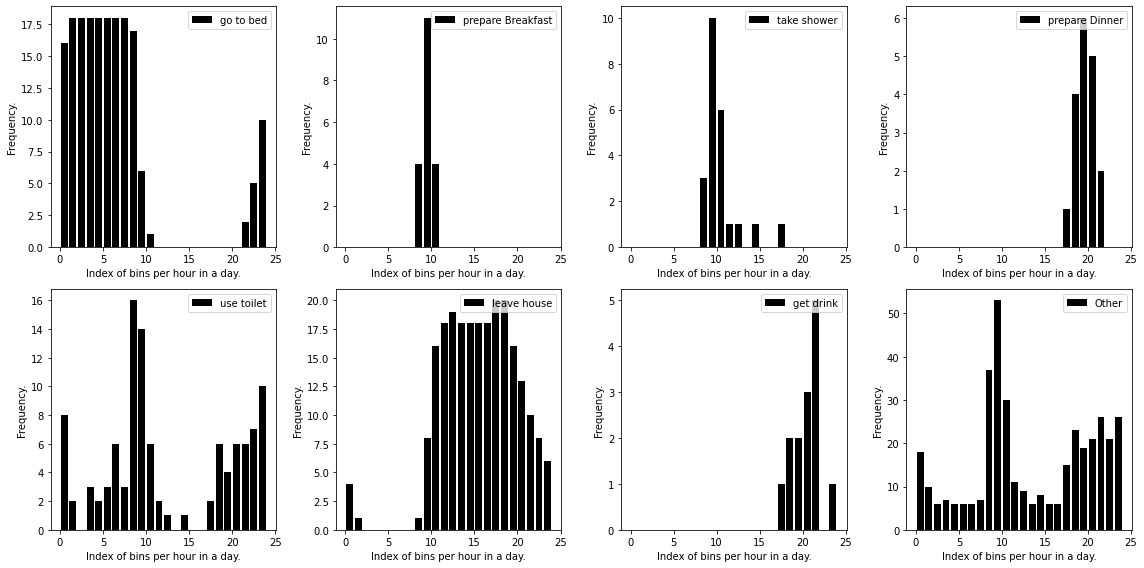

In [9]:
# load kasteren dataset
path = Path("./kasterenDataset/kasterenActData.txt")
kasteren = comparison.load_kasterenActData(
    path,
    first_date=datetime.datetime(year=2008, month=2, day=26),
    last_date=datetime.datetime(year=2008, month=3, day=20),
    remove_exception=True,
)
kasteren_days = comparison.convert_data_into_days(kasteren)
activity_names = []
for a in kasteren:
    if a[0] not in activity_names:
        activity_names.append(a[0])
activity_names = [activity_names[i] for i in [0, 3, 4, 7, 1, 5, 6, 2]]


# plot data
temp_dict = {a: None for a in activity_names}
interval_len = timedelta(hours=1)  # must be less than 24[h]
step_len = interval_len / timedelta(hours=24)
t_list = list(
    utils.date_generator(timedelta(hours=0), timedelta(hours=24), step=interval_len)
)
plot_x = [24 * i * step_len for i in range(len(t_list))]
plot_x = [x + 24 * step_len / 2 for x in plot_x]

for activity_name in activity_names:
    plot_y = [0 for i in t_list]
    for i, t in enumerate(t_list):
        interval = utils.TimeInterval(t, t + interval_len)
        for day in kasteren_days:
            for a in day:
                if a[0] == activity_name and a[1].overlap(interval) == True:
                    plot_y[i] += 1
    temp_dict[activity_name] = plot_y

fig = plt.figure(figsize=(16, 8))
axs = [fig.add_subplot(2, 4, i) for i in range(1, 9)]
for i, a in enumerate(activity_names):
    axs[i].set_xlabel("Index of bins per hour in a day.")
    axs[i].set_ylabel("Frequency.")
    axs[i].bar(plot_x, temp_dict[a], label=a, color="k")
    axs[i].legend(loc="upper right")
fig.tight_layout()
plt.show()
plt.close()

### Check daily frequencies of activities histogram per day of Kasteren dataset

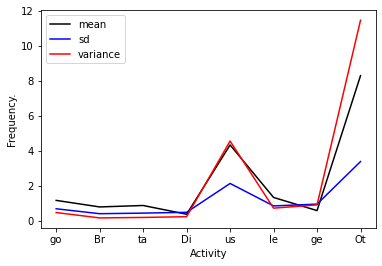

In [10]:
# load kasteren dataset
path = Path("./kasterenDataset/kasterenActData.txt")
kasteren = comparison.load_kasterenActData(
    path,
    first_date=datetime.datetime(year=2008, month=2, day=26),
    last_date=datetime.datetime(year=2008, month=3, day=20),
    remove_exception=True,
)
kasteren_days = comparison.convert_data_into_days(kasteren)
activity_names = []
for a in kasteren:
    if a[0] not in activity_names:
        activity_names.append(a[0])
activity_names = [activity_names[i] for i in [0, 3, 4, 7, 1, 5, 6, 2]]

# plot data
freq_mean, freq_sd = comparison.estimate_daily_frequency(kasteren, activity_names)
plot_mean = [freq_mean[a] for a in activity_names]
plot_sd = [freq_sd[a] for a in activity_names]
plot_var = [x**2 for x in plot_sd]
plot_x = []
for n in activity_names:  # Abbreviations of activities.
    if n == "prepare Breakfast":
        plot_x.append("Br")
    elif n == "prepare Dinner":
        plot_x.append("Di")
    else:
        plot_x.append(n[:2])

plt.plot(plot_x, plot_mean, c="black", label="mean")
plt.plot(plot_x, plot_sd, c="blue", label="sd")
plt.plot(plot_x, plot_var, c="r", label="variance")
plt.xlabel("Activity")
plt.ylabel("Frequency.")
plt.legend()
plt.show()
plt.close()

### Statistics of activities in Kasteren dataset

Mean start time [hour]: {'go to bed': 23.6023003966612, 'prepare Breakfast': 9.379046430868078, 'take shower': 10.316988426441783, 'prepare Dinner': 19.329628403976432}
SD of start time [hour]: {'go to bed': 1.227236016195215, 'prepare Breakfast': 0.6405681398371801, 'take shower': 2.051722853149245, 'prepare Dinner': 0.8577394594875589}
Mean duration time [hour]: {'go to bed': 9.267875816993463, 'use toilet': 0.030072115384615388, 'Other': 1.0224838330393888, 'prepare Breakfast': 0.05570175438596491, 'take shower': 0.1608201058201058, 'leave house': 7.276706349206348, 'get drink': 0.015912698412698413, 'prepare Dinner': 0.5551851851851852}
SD of start time [hour]: {'go to bed': 1.297650941532453, 'use toilet': 0.028945103589915533, 'Other': 5.029436041148936, 'prepare Breakfast': 0.042581226932893367, 'take shower': 0.043955936011301155, 'leave house': 3.5500820862611744, 'get drink': 0.02200224169160457, 'prepare Dinner': 0.32561930547614254}
Mean daily frequency [times/day]: {'go to

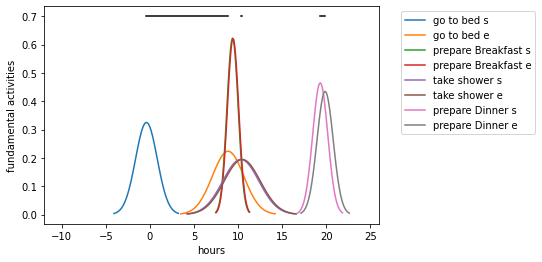

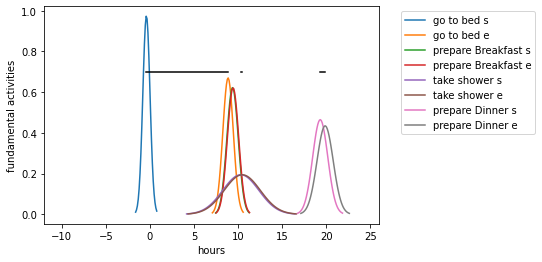

In [19]:
# load kasteren dataset
path = Path("./kasterenDataset/kasterenActData.txt")
kasteren = comparison.load_kasterenActData(
    path,
    first_date=datetime.datetime(year=2008, month=2, day=26),
    last_date=datetime.datetime(year=2008, month=3, day=20),
    remove_exception=True,
)
kasteren_days = comparison.convert_data_into_days(kasteren)
activity_names = []
for a in kasteren:
    if a[0] not in activity_names:
        activity_names.append(a[0])
activity_names = [activity_names[i] for i in [0, 3, 4, 7, 1, 5, 6, 2]]

# learn the fundamental parameters
fundamental_act_names = [
    "go to bed",
    "prepare Breakfast",
    "take shower",
    "prepare Dinner",
]
start_hour_mean, start_hour_sd = comparison.estimate_start_time(
    kasteren, fundamental_act_names
)
duration_hour_mean, duration_hour_sd = comparison.estimate_duration_time(kasteren)
freq_mean, freq_sd = comparison.estimate_daily_frequency(kasteren)

print("Mean start time [hour]: {}".format(start_hour_mean))
print("SD of start time [hour]: {}".format(start_hour_sd))
print("Mean duration time [hour]: {}".format(duration_hour_mean))
print("SD of start time [hour]: {}".format(duration_hour_sd))
print("Mean daily frequency [times/day]: {}".format(freq_mean))
print("SD of daily frequency [times/day]: {}".format(freq_sd))

# It estimates normal distributions of start time and end_time of each fundamental activity.
for a in fundamental_act_names:
    mu_s, sigma_s = start_hour_mean[a], start_hour_sd[a]
    mu_d, sigma_d = duration_hour_mean[a], duration_hour_sd[a]
    if a == "go to bed" and mu_s > 12:
        mu_s -= 24
    X_s = np.arange(mu_s - 3 * sigma_s, mu_s + 3 * sigma_s, 0.1)
    Y_s = stats.norm.pdf(X_s, mu_s, sigma_s)
    mu_e, sigma_e = mu_s + mu_d, np.sqrt(sigma_s**2 + sigma_d**2)
    X_e = np.arange(mu_e - 3 * sigma_e, mu_e + 3 * sigma_e, 0.1)
    Y_e = stats.norm.pdf(X_e, mu_e, sigma_e)
    plt.plot(X_s, Y_s, label=a + " s")  # start time
    plt.plot(X_e, Y_e, label=a + " e")  # end time
    plt.plot([mu_s, mu_e], [0.7, 0.7], c="k")
plt.xlim(-12, 26)
plt.xlabel("hours")
plt.ylabel("fundamental activities")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()
plt.close()

### Modification of sleeping parameters to avoid overlap.
start_hour_sd["go to bed"] = start_hour_sd["go to bed"] / 3
duration_hour_sd["go to bed"] = duration_hour_sd["go to bed"] / 3

for a in fundamental_act_names:
    mu_s, sigma_s = start_hour_mean[a], start_hour_sd[a]
    mu_d, sigma_d = duration_hour_mean[a], duration_hour_sd[a]
    if a == "go to bed" and mu_s > 12:
        mu_s -= 24
    X_s = np.arange(mu_s - 3 * sigma_s, mu_s + 3 * sigma_s, 0.1)
    Y_s = stats.norm.pdf(X_s, mu_s, sigma_s)
    mu_e, sigma_e = mu_s + mu_d, np.sqrt(sigma_s**2 + sigma_d**2)
    X_e = np.arange(mu_e - 3 * sigma_e, mu_e + 3 * sigma_e, 0.1)
    Y_e = stats.norm.pdf(X_e, mu_e, sigma_e)
    plt.plot(X_s, Y_s, label=a + " s")  # start time
    plt.plot(X_e, Y_e, label=a + " e")  # end time
    plt.plot([mu_s, mu_e], [0.7, 0.7], c="k")
plt.xlim(-12, 26)
plt.xlabel("hours")
plt.ylabel("fundamental activities")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()
plt.close()

### Generate some datasets for comparison

In [2]:
# modify_sleep_param determines
# whether to shrink (1) the standard deviation of start time of 'go to bed' and,
#                   (2) the standard deviation of duration time of 'go to bed'
# to avoid overlap between 'go to bed' and 'prepare Breakfast'.
modify_sleep_param = True

path = Path(layout_data_path / "test_layout")
# This 'path' does not affect simulated data, but needs to use the function generate_activity_sequence.

# load kasteren dataset
kasteren_path = Path("./kasterenDataset/kasterenActData.txt")
kasteren = comparison.load_kasterenActData(
    kasteren_path,
    first_date=datetime.datetime(year=2008, month=2, day=26),
    last_date=datetime.datetime(year=2008, month=3, day=20),
    add_other=True,
    remove_exception=False,
)
train = comparison.load_kasterenActData(
    kasteren_path,
    first_date=datetime.datetime(year=2008, month=2, day=26),
    last_date=datetime.datetime(year=2008, month=3, day=20),
    add_other=True,
    remove_exception=True,
)
kasteren_days = comparison.convert_data_into_days(kasteren)
activity_names = []
for a in kasteren:
    if a[0] not in activity_names:
        activity_names.append(a[0])
activity_names = [activity_names[i] for i in [0, 3, 4, 7, 1, 5, 6, 2]]
start_day, end_day = 0, len(kasteren_days) - 1

kasteren_act_model = comparison.kasteren_activity_model(
    train, modify_sleep_param=modify_sleep_param
)
kasteren_act_model_sleep = comparison.kasteren_activity_model_sleep_only(
    train, modify_sleep_param=modify_sleep_param
)
duration_hour_mean, duration_hour_sd = comparison.estimate_duration_time(
    train, activity_names
)
mean_list = [
    timedelta(hours=duration_hour_mean[a]) / timedelta(minutes=1)
    for a in activity_names
]
sd_list = [
    timedelta(hours=duration_hour_sd[a]) / timedelta(minutes=1) for a in activity_names
]


# Simulation of each dataset is repeated 'N' times.
N = 10
N_days_kasteren = []
N_days_simulation = []
N_days_RD = []  # random duration and random order (RD)
N_days_RS = []  # random duration except for sleep (RS)

for i in range(N):
    # All elements in N_days_kasteren are same. This is redundancy, but has uniformity compared to other N_days data.
    N_days_kasteren.append(kasteren_days)

    simulation = utils.generate_activity_sequence(
        start_day, end_day, path, original_act_model=kasteren_act_model
    )
    # change the format of the activity sequence.
    for i, a in enumerate(simulation):
        simulation[i] = (a.activity.name, utils.TimeInterval(a.start, a.end))
    N_days_simulation.append(comparison.convert_data_into_days(simulation))

    random_data = comparison.generate_random_activity_sequence(
        start_day, end_day, activity_names, mean_list, sd_list
    )
    N_days_RD.append(comparison.convert_data_into_days(random_data))

    random_data_sleep = utils.generate_activity_sequence(
        start_day, end_day, path, original_act_model=kasteren_act_model_sleep
    )
    for i, a in enumerate(random_data_sleep):
        random_data_sleep[i] = (a.activity.name, utils.TimeInterval(a.start, a.end))
    N_days_RS.append(comparison.convert_data_into_days(random_data_sleep))

### Compare some datasets by edit distance

#### rho(kasteren)

In [3]:
time_duration = timedelta(
    seconds=30
)  # Unit time interval that is converted into one character.
rho_kasteren = comparison.same_days_distance(kasteren_days, time_duration)
print("rho(kasteren): {}.".format(rho_kasteren))

converting days into strings, 100% completed!
calculate distances, 100% completed!
rho(kasteren): (1027.8188405797102, 500.7003390253546).


#### rho(simulation), rho(RD), rho(RS), delta_intra(simulation), delta_intra(RD), delta_intra(RS).

In [4]:
time_duration = timedelta(seconds=30)

mean_list_S, _ = comparison.mean_same_days_distance(
    N_days_simulation, time_duration, print_progress=False
)
print(
    "rho(simulation): {} (± {}).".format(
        np.mean(mean_list_S), np.sqrt(np.var(mean_list_S))
    )
)

mean_list_RD, _ = comparison.mean_same_days_distance(
    N_days_RD, time_duration, print_progress=False
)
print(
    "rho(RD): {} (± {}).".format(np.mean(mean_list_RD), np.sqrt(np.var(mean_list_RD)))
)

mean_list_RS, _ = comparison.mean_same_days_distance(
    N_days_RS, time_duration, print_progress=False
)
print(
    "rho(RS): {} (± {}).".format(np.mean(mean_list_RS), np.sqrt(np.var(mean_list_RS)))
)

delta_intra_S = np.array(mean_list_S) - rho_kasteren[0]
print(
    "delta_intra(simulation): {} (± {}).".format(
        np.mean(delta_intra_S), np.sqrt(np.var(delta_intra_S))
    )
)

delta_intra_RD = np.array(mean_list_RD) - rho_kasteren[0]
print(
    "delta_intra(RD): {} (± {}).".format(
        np.mean(delta_intra_RD), np.sqrt(np.var(delta_intra_RD))
    )
)

delta_intra_RS = np.array(mean_list_RS) - rho_kasteren[0]
print(
    "delta_intra(RS): {} (± {}).".format(
        np.mean(delta_intra_RS), np.sqrt(np.var(delta_intra_RS))
    )
)

rho(simulation): 923.1177536231884 (± 31.29757111172007).
rho(RD): 1567.9989130434783 (± 45.860264043414524).
rho(RS): 799.9547101449275 (± 76.82590436582414).
delta_intra(simulation): -104.70108695652183 (± 31.297571111720067).
delta_intra(RD): 540.180072463768 (± 45.860264043414524).
delta_intra(RS): -227.86413043478268 (± 76.82590436582414).


#### rho(simulation, kasteren), rho(RD, kasteren), rho(RS, kasteren), delta_inter(simulation), delta_inter(RD), delta_inter(RS).

In [5]:
time_duration = timedelta(seconds=30)
mean_list_S_k, _ = comparison.mean_different_days_distance(
    N_days_simulation, N_days_kasteren, time_duration, print_progress=False
)
print(
    "rho(simulation, kasteren): {} (± {}).".format(
        np.mean(mean_list_S_k), np.sqrt(np.var(mean_list_S_k))
    )
)

mean_list_RD_k, _ = comparison.mean_different_days_distance(
    N_days_RD, N_days_kasteren, time_duration, print_progress=False
)
print(
    "rho(RD, kasteren): {} (± {}).".format(
        np.mean(mean_list_RD_k), np.sqrt(np.var(mean_list_RD_k))
    )
)

mean_list_RS_k, _ = comparison.mean_different_days_distance(
    N_days_RS, N_days_kasteren, time_duration, print_progress=False
)
print(
    "rho(RS, kasteren): {} (± {}).".format(
        np.mean(mean_list_RS_k), np.sqrt(np.var(mean_list_RS_k))
    )
)

delta_inter_S = np.array(mean_list_S_k) - rho_kasteren[0]
print(
    "delta_inter(simulation): {} (± {}).".format(
        np.mean(delta_inter_S), np.sqrt(np.var(delta_inter_S))
    )
)

delta_inter_RD = np.array(mean_list_RD_k) - rho_kasteren[0]
print(
    "delta_inter(RD): {} (± {}).".format(
        np.mean(delta_inter_RD), np.sqrt(np.var(delta_inter_RD))
    )
)

delta_inter_RS = np.array(mean_list_RS_k) - rho_kasteren[0]
print(
    "delta_inter(RS): {} (± {}).".format(
        np.mean(delta_inter_RS), np.sqrt(np.var(delta_inter_RS))
    )
)

rho(simulation, kasteren): 1262.2739583333332 (± 35.360192837222094).
rho(RD, kasteren): 1676.809375 (± 106.81046562546963).
rho(RS, kasteren): 1004.5125 (± 46.79647206848523).
delta_inter(simulation): 234.4551177536231 (± 35.360192837222094).
delta_inter(RD): 648.9905344202898 (± 106.81046562546963).
delta_inter(RS): -23.30634057971024 (± 46.79647206848523).


## Comparison between Aruba dataset and simulation dataset by hamming distance.
CASAS Aruba dataset [1] D. Cook et al., "CASAS: A Smart Home in a Box." IEEE Computer, 46-7(2013), 62-69.

In [ ]:
# prepare informations to evaluate
import itertools
import matplotlib.pyplot as plt
import random
import statistics

# Aruba dataset
Aruba_path = Path("./aruba/data")
# Aruba_path = str(Path('C:/Users/tanakai/Documents/aruba/data'))
Aruba = comparison.load_CASAS_Aruba(Aruba_path)

# simulation dataset
start_day, end_day = 0, 219
act_model = activity_model.determine_activity_set(
    path, activity_model.applied_activity_model_2
)
simulation = utils.generate_activity_sequence(
    start_day=start_day, end_day=end_day, act_model=act_model
)
print("Activity scheduling is completed.")

for i, a in enumerate(simulation):
    simulation[i] = (a[0].name, utils.TimeInterval(a[1], a[2]))

# random dataset
activity_list = []
for k, v in activity_model.basic_activity_model.items():
    if k != "walking_activities":
        for i in v:
            activity_list.append(i)
name_list, mean_list, sd_list = [], [], []
for act in activity_list:
    name_list.append(act.name)
    mean_list.append(act.duration_mean)
    sd_list.append(act.duration_sd)
random_data = comparison.generate_random_activity_sequence(
    0, 219, name_list, mean_list, sd_list
)


# make informations for metric
def make_A_D_m_matrix(data):
    # data[i] = (name of i-th activity, utils.TimeInterval class)
    start_day, end_day = data[0][1].start.days, data[-1][1].start.days
    label_list = []
    for x in data:
        if x[0] not in label_list:
            label_list.append(x[0])
    M_A = {
        label_list[i]: np.zeros((end_day - start_day + 1, 1440))
        for i in range(len(label_list))
    }
    # M_A['a'] = ndarray for activity 'a', M_A['a'][d][m] = whether 'a' was taken in m-minutes in the d-th day
    index = 0
    activity = data[index]
    start, stop = timedelta(days=start_day), timedelta(
        days=end_day, hours=24
    ) - timedelta(microseconds=1)
    count = 0
    for t in utils.date_generator(start, stop, step=timedelta(minutes=1)):
        while activity[1].end < t:
            index += 1
            activity = data[index]
        day, hour, minute, _, _ = utils.get_d_h_m_s_ms(t)
        minute_in_a_day = int(hour) * 60 + int(minute)
        M_A[activity[0]][int(day)][minute_in_a_day] = 1
    return M_A


def make_weight_dict(data):
    # weight_dict = weights by total hours that each activity spend in the data
    weight_dict = {}
    for x in data:
        if x[0] not in weight_dict.keys():
            weight_dict[x[0]] = 0
        weight_dict[x[0]] += (x[1].end - x[1].start) / timedelta(hours=1)
    total_hours = (data[-1][1].end - data[0][1].start) / timedelta(hours=1)
    for k in weight_dict.keys():
        weight_dict[k] /= total_hours
    return weight_dict


# data = Aruba
data = simulation
# data = random_data
M_A = make_A_D_m_matrix(data)
weight_dict = make_weight_dict(data)
print(M_A.keys())

In [ ]:
# evaluation
def hamming_distance(a, b):
    ret = 0
    for i in range(len(a)):
        ret += int(a[i] != b[i])
    return ret


def skewness(num_list, mean, sd):
    n = len(num_list)
    temp = 0
    for x in num_list:
        temp += (x - mean) ** 3
    return temp / n / (sd**3)


def kurtosis(num_list, mean, variance):
    n = len(num_list)
    temp = 0
    for x in num_list:
        temp += (x - mean) ** 4
    return temp / n / (variance**2) - 3


is_weight = True  # whether hamming distances of each activity are weighted
target_act_list = ["Clean"]
# target_act_list = list(M_A.keys())

dh_list = []
day_num = random.choice(list(M_A.values())).shape[0]
all_act = len(target_act_list) == len(list(M_A.keys()))
count = 0
count_max = day_num * (day_num - 1) / 2
for i, j in itertools.combinations([k for k in range(day_num)], 2):
    ret = 0
    for a in target_act_list:
        w = 1
        if all_act == True and is_weight == True:
            w = weight_dict[a]
        ret += w * hamming_distance(M_A[a][i], M_A[a][j])
    dh_list.append(ret)
    if (count % int(count_max / 10)) == 0:
        print("{} / {} completed.".format(count, count_max))
    count += 1

bins = int(max(dh_list) / 2)
graph_title = ""
if len(target_act_list) == len(list(M_A.keys())):
    graph_title = "all activities"
else:
    graph_title = target_act_list[0]
mean = statistics.mean(dh_list)
sd = statistics.stdev(dh_list)
skew = skewness(dh_list, mean, sd)
kurt = kurtosis(dh_list, mean, statistics.pvariance(dh_list))
plt.hist(dh_list, bins=bins)
plt.title(
    "histogram of hamming distance of {}(bin: {:.2f})\n".format(graph_title, bins)
    + "min: {:.2f}, max:{:.2f}\n".format(min(dh_list), max(dh_list))
    + "mean: {:.2f}, sd: {:.2f}\n".format(mean, sd)
    + "skewness: {:.2f}, kurtosis: {:.2f}".format(skew, kurt)
)
plt.xlabel("distance")
plt.ylabel("freq.")
plt.show()
plt.close()

# Figures

## MMSE and parameters of wandering

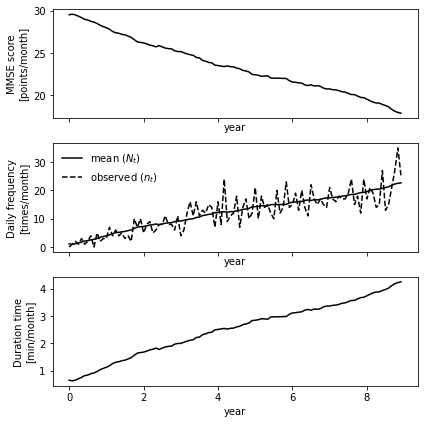

In [10]:
start, end, step = timedelta(days=0), timedelta(days=9 * 360), timedelta(days=30)
MMSE = anomaly_model.simulate_MMSE(start, end, step, error_e=0)


# about wandering
def calculate_wandering_num(mmse):
    # decide the number of wandering
    if mmse < 0 or 30 < mmse:
        raise ValueError("mmse must be 0 <= mmse <= 30")
    return -1.86 * mmse + 56


def calculate_wandering_duration(mmse):
    # decide the duration time of wandering
    if mmse < 0 or 30 < mmse:
        raise ValueError("mmse must be 0 <= mmse <= 30")
    return -0.31 * mmse + 9.8


wandering_mean_num = anomaly_model.simulate_values_from_MMSE(
    MMSE, start, end, step, calculate_wandering_num
)
wandering_num = [(x[0], x[1], stats.poisson.rvs(x[2])) for x in wandering_mean_num]
wandering_mean_duration = anomaly_model.simulate_values_from_MMSE(
    MMSE, start, end, step, calculate_wandering_duration
)

# graph
graph_time_step = timedelta(days=30 * 12)
fig, ax = plt.subplots(3, 1, sharex="col", facecolor="w", figsize=(6, 6))
ax[0].plot([x[0] / graph_time_step for x in MMSE], [x[2] for x in MMSE], "k-")
ax[0].set_xlabel("year")
ax[0].set_ylabel("MMSE score\n[points/month]")
ax[1].plot(
    [x[0] / graph_time_step for x in wandering_mean_num],
    [x[2] for x in wandering_mean_num],
    "k-",
    label="mean ($N_t$)",
)
ax[1].plot(
    [x[0] / graph_time_step for x in wandering_num],
    [x[2] for x in wandering_num],
    "k--",
    label="observed ($n_t$)",
)
ax[1].legend(loc="best", frameon=False)
ax[1].set_xlabel("year")
ax[1].set_ylabel("Daily frequency\n[times/month]")
ax[2].plot(
    [x[0] / graph_time_step for x in wandering_mean_duration],
    [x[2] for x in wandering_mean_duration],
    "k-",
    label="mean($D_t$)",
)
ax[2].set_xlabel("year")
ax[2].set_ylabel("Duration time\n[min/month]")
plt.tight_layout()
save_file_name = "wandering_simulations"
plt.savefig("{}.png".format(save_file_name), dpi=500)
plt.show()
plt.close()

# sensor responce around fall

In [2]:
temp_time = time.time()

# test layout
path = Path(layout_data_path / "3/WARDeSoDTAKSCBRFAWMTB/1596,960,2100,222,0LL")
data_save_path = utils.generate_data_folder(path, utils.present_date_and_time())

# MMSE score
start, end, step = timedelta(days=0), timedelta(days=9 * 360), timedelta(days=30)
MMSE = anomaly_model.simulate_MMSE(start, end, step, error_e=0)


def calculate_falling_mean_num(mmse):
    # decide the mean number of falling
    if mmse < 0 or 30 < mmse:
        raise ValueError("mmse must be 0 <= mmse <= 30")
    return -mmse / 15 + 2


# falling while walking
fall_w_mean_num = anomaly_model.simulate_values_from_MMSE(
    MMSE, start, end, step, calculate_falling_mean_num
)
fall_w_num = [(x[0], x[1], stats.poisson.rvs(x[2])) for x in fall_w_mean_num]

# fall while standing
fall_s_mean_num = anomaly_model.simulate_values_from_MMSE(
    MMSE, start, end, step, calculate_falling_mean_num
)
fall_s_num = [(x[0], x[1], stats.poisson.rvs(x[2])) for x in fall_s_mean_num]

# ------------------------------------------------------------------------------------
fall_w_num = [(x[0], x[1], x[2] + 2) for x in fall_w_num]  # test setting!!!!!
fall_s_num = [(x[0], x[1], x[2] + 2) for x in fall_s_num]  # test setting!!!!!
# ------------------------------------------------------------------------------------

# fall_s_info['place'] defines the places that a resident has the possibility to falling from high place
fall_s_place_bed = ["Bed"]
fall_s_place = ["Bed", "Sofa", "Dinner_Table_Chair", "Desk_Chair"]

fall_w_parameters = {"num": fall_w_num, "mean_lie_down_seconds": 30}
fall_s_parameters = {
    "num": fall_s_num,
    "mean_lie_down_seconds": 30,
    "place": fall_s_place_bed,
}

anomaly_model.save_MMSE(data_save_path, MMSE)
anomaly_model.save_anomaly_parameters(
    data_save_path, fall_w_parameters, "fall_w_parameters"
)
anomaly_model.save_anomaly_parameters(
    data_save_path, fall_s_parameters, "fall_s_parameters"
)

# generate an activity sequence (AS) and save it
AS = utils.generate_activity_sequence(
    0, 7, path, original_act_model=activity_model.basic_activity_model
)
print("An activity sequence was generated in {} [s].".format(time.time() - temp_time))
utils.save_activity_sequence(data_save_path, AS)
utils.save_activity_sequence_as_image(data_save_path, AS)

# generate walking trajectories (WT) and save it
indoor_movement = activity_model.indoor_movement  # parameters about walking
WT = utils.generate_walking_trajectories(
    path,
    AS,
    indoor_movement.stride,
    indoor_movement.step_speed,
    indoor_movement.prefer_foot,
    fall_w_parameters=fall_w_parameters,
    fall_s_parameters=fall_s_parameters,
)
print("Walking trajectories were generated in {} [s].".format(time.time() - temp_time))
utils.save_walking_trajectoires(data_save_path, WT)
anomaly_model.save_fall_labels(data_save_path, WT)

print("Path that a fall while walking and a fall while standing both occurr: ")
for i, wt in enumerate(WT):
    if wt.fall_w == True and wt.fall_s == True:
        utils.save_layout(
            data_save_path, path, WT=[wt], filename="{}-th path".format(i)
        )
        print(
            "  w: For {} seconds from {} at {}-th step during a path from {} to {}.".format(
                wt.lie_down_seconds_w,
                wt.timestamp[wt.fall_w_index],
                wt.fall_w_index,
                wt.start_place,
                wt.end_place,
            )
        )
        # print("{} == duration: {}".format(wt.lie_down_seconds_w, wt.timestamp[wt.fall_s_index + 1] - wt.timestamp[wt.fall_s_index]))
        print(
            "  s: For {} seconds from {} at {}-th step during a path from {} to {}.".format(
                wt.lie_down_seconds_s,
                wt.timestamp[wt.fall_s_index],
                wt.fall_s_index,
                wt.start_place,
                wt.end_place,
            )
        )
print("Path that a fall while walking occurrs: ")
for i, wt in enumerate(WT):
    if wt.fall_w == True and wt.fall_s == False:
        utils.save_layout(
            data_save_path, path, WT=[wt], filename="{}-th path".format(i)
        )
        print(
            "  For {} seconds from {} at {}-th step during a path from {} to {}.".format(
                wt.lie_down_seconds_w,
                wt.timestamp[wt.fall_w_index],
                wt.fall_w_index,
                wt.start_place,
                wt.end_place,
            )
        )
print("Path that a fall while standing occurrs: ")
for i, wt in enumerate(WT):
    if wt.fall_w == False and wt.fall_s == True:
        utils.save_layout(
            data_save_path, path, WT=[wt], filename="{}-th path".format(i)
        )
        print(
            "  For {} seconds from {} at {}-th step during a path from {} to {}.".format(
                wt.lie_down_seconds_s,
                wt.timestamp[wt.fall_s_index],
                wt.fall_s_index,
                wt.start_place,
                wt.end_place,
            )
        )

temp_time = time.time()

# sensor arrangement
sensors = sensor_model.test_sensors  # for 3/WARDeSoDTAKSCBRFAWMTB/1596,960,2100,222,0LL

# simulate sensor data that is related with resident's move.
motion_sensor_data = utils.generate_motion_sensor_data(
    sensors, WT, sampling_seconds=0.1, sync_reference_point=AS[0].start, body_radius=10
)
print("Sensor data was simulated in {}[s].".format(time.time() - temp_time))

# save the sensor data as a text file
utils.save_binary_sensor_data(
    data_save_path, sensors, motion_sensor_data, filename="PIR_pressure"
)  # all sensor data

# save the figure of walking trajectories that falls occur
for i, wt in enumerate(WT):
    if wt.fall_w == True and wt.fall_s == True:
        w_c = (wt.centers[wt.fall_w_index][0], wt.centers[wt.fall_w_index][1])
        s_c = (wt.centers[wt.fall_s_index][0], wt.centers[wt.fall_s_index][1])
        file_name = "{}-th path with fall_w at ({},{}) and fall_s at ({}, {})".format(
            i, w_c[0], w_c[1], s_c[0], s_c[1]
        )
        utils.save_layout(
            data_save_path,
            path,
            sensors=sensors,
            WT=[wt],
            filename=file_name,
            mark_point=[w_c, s_c],
        )
        wt.save_with_sensor_activations(
            data_save_path,
            "sensor_activation_in_{}-th_path".format(i),
            motion_sensor_data,
        )
for i, wt in enumerate(WT):
    if wt.fall_w == True and wt.fall_s == False:
        w_c = (wt.centers[wt.fall_w_index][0], wt.centers[wt.fall_w_index][1])
        file_name = "{}-th path with fall_w at ({},{})".format(i, w_c[0], w_c[1])
        utils.save_layout(
            data_save_path,
            path,
            sensors=sensors,
            WT=[wt],
            filename=file_name,
            mark_point=[w_c],
        )
        wt.save_with_sensor_activations(
            data_save_path,
            "sensor_activation_in_{}-th_path".format(i),
            motion_sensor_data,
        )
for i, wt in enumerate(WT):
    if wt.fall_w == False and wt.fall_s == True:
        s_c = (wt.centers[wt.fall_s_index][0], wt.centers[wt.fall_s_index][1])
        file_name = "{}-th path with fall_s at ({},{})".format(i, s_c[0], s_c[1])
        utils.save_layout(
            data_save_path,
            path,
            sensors=sensors,
            WT=[wt],
            filename=file_name,
            mark_point=[s_c],
        )
        wt.save_with_sensor_activations(
            data_save_path,
            "sensor_activation_in_{}-th_path".format(i),
            motion_sensor_data,
        )

print("Figures are saved in {}[s].".format(time.time() - temp_time))

An activity sequence was generated in 0.030899524688720703 [s].
{'Do laundry', 'Rest', 'Have breakfast', 'Watch TV', 'Change clothes', 'Take a bath', 'Have lunch', 'Have dinner', 'Cooking', 'Clean', 'Read', 'Take a snack', 'Use the phone', 'Brush teeth', 'Defecation', 'Sleep', 'Go out', 'Urination'}
Walking trajectories were generated in 20.875447511672974 [s].
Path that a fall while walking and a fall while standing both occurr: 
Path that a fall while walking occurrs: 
  For 41.92317585029866 seconds from 6 days, 10:24:19.614641 at 5-th step during a path from Desk_Chair to Toilet_Door.
  For 26.136984524607612 seconds from 6 days, 19:37:45.698890 at 1-th step during a path from Sofa to Trash_Bin.
Path that a fall while standing occurrs: 
  For 27.814477892101507 seconds from 5:48:29.805351 at 0-th step during a path from Bed to Kitchen_Stove.
  For 32.43810530306562 seconds from 3 days, 4:48:33.378425 at 0-th step during a path from Bed to Sofa.
Sensor data was simulated in 17.38005

In [5]:
n = 12
file_name = "{}-th path".format(n)
utils.save_layout(data_save_path, path, sensors=sensors, WT=[WT[n]], filename=file_name)
WT[n].save_with_sensor_activations(
    data_save_path, "sensor_activation_in_{}-th_path".format(n), motion_sensor_data
)

# Spike raster plot of anomalies

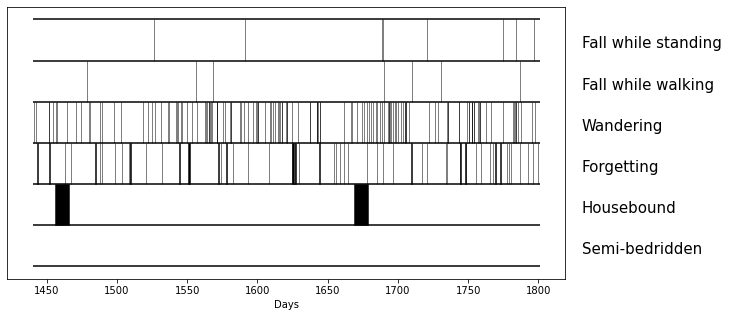

In [11]:
import matplotlib.patches as patches

housebound_labels = anomaly_model.simulate_state_anomaly_periods(
    MMSE, 1 / 10, 14, 14 / 5
)
semi_bedridden_labels = anomaly_model.simulate_state_anomaly_periods(
    MMSE, 1 / 20, 30, 30 / 5
)

x_range = (AS[0].start.days, AS[-1].end.days + 1)
interval_dict = {}
y_dict = {}

interval_dict["Semi-bedridden"] = []
for s_range in semi_bedridden_labels:
    if not (s_range[-1].days < x_range[0] or x_range[1] < s_range[0].days):
        interval_dict["Semi-bedridden"].append(s_range)
y_dict["Semi-bedridden"] = (0, 1)

interval_dict["Housebound"] = []
for h_range in housebound_labels:
    if not (h_range[-1].days < x_range[0] or x_range[1] < h_range[0].days):
        interval_dict["Housebound"].append(h_range)
y_dict["Housebound"] = (1, 2)

interval_dict["Forgetting"] = []
for x in forgetting_labels:
    if not (x[4].days < x_range[0] or x_range[1] < x[5].days):
        interval_dict["Forgetting"].append((x[4], x[5]))
y_dict["Forgetting"] = (2, 3)

interval_dict["Wandering"] = []
for i in wandering_result:
    wt = WT[i]
    if not (wt.start_time.days < x_range[0] or x_range[1] < wt.end_time.days):
        interval_dict["Wandering"].append((wt.start_time, wt.end_time))
y_dict["Wandering"] = (3, 4)

interval_dict["Fall while walking"] = []
for i, wt in enumerate(WT):
    if wt.fall_w == True:
        s, e = wt.timestamp[wt.fall_w_index], wt.timestamp[wt.fall_w_index] + timedelta(
            seconds=wt.lie_down_seconds_w
        )
        if not ((s.days < x_range[0]) or (x_range[1] < e.days)):
            interval_dict["Fall while walking"].append((s, e))
y_dict["Fall while walking"] = (4, 5)

interval_dict["Fall while standing"] = []
for i, wt in enumerate(WT):
    if wt.fall_s == True:
        s, e = wt.timestamp[wt.fall_s_index], wt.timestamp[wt.fall_s_index] + timedelta(
            seconds=wt.lie_down_seconds_s
        )
        if not ((s.days < x_range[0]) or (x_range[1] < e.days)):
            interval_dict["Fall while standing"].append((s, e))
y_dict["Fall while standing"] = (5, 6)

fig_name = "Anomaly_occurrence.png"

fig = plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.set_xlabel("Days")
for k, y in y_dict.items():
    ax.text(x_range[-1] + 30, y[0] + 0.3, k, size=15)
ax.tick_params(bottom=True, left=False, right=False, top=False)
ax.tick_params(labelbottom=True, labelleft=False)
for i in range(7):
    ax.hlines(i, x_range[0], x_range[1], color="black")
for k, anomaly_list in interval_dict.items():
    for a in anomaly_list:
        s, e = a[0] / timedelta(days=1), a[1] / timedelta(days=1)
        ax.add_patch(
            patches.Rectangle(
                xy=(s, y_dict[k][0]),
                width=e - s,
                height=1,
                ec="black",
                fc="black",
                fill=True,
                lw=0.5,
            )
        )

plt.savefig(data_save_path / Path(fig_name), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Estimate walking speed by mean average distances

- 全てのセンサを使った場合，歩速が遅くなるほど本来よりも推定歩速が速めになる傾向にある？
- 歩行途中をとらえるセンサのみを使った場合，歩速が速くなるほど推定歩速が本来よりも遅めになる傾向にある？

- [ ] 全てのセンサに対して，歩速を変化させたときの，推定歩速 - 真の歩速　をプロットして確認  
- [ ] 歩行途中をとらえるセンサに対して，歩速を変化させたときの，推定歩速 - 真の歩速　をプロットして確認

それとも歩幅とセンサのサンプリングレートに関係あり？

Mean distance: 63.66197723675813.
Mean walking speed: (67.31884749840951, 83.8681669387308).
True walking speed: 68.75.


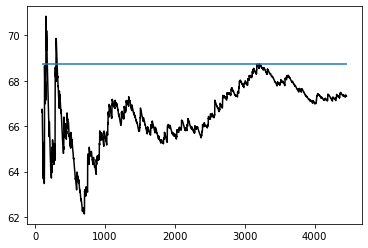

In [2]:
# sensor_data = analysis.load_sensor_data(Path('./test_data/PIR_pressure.txt'))
# activity_data = analysis.load_activity_sequence(Path('./test_data/activity_sequence.txt'))

sensor_data = analysis.load_sensor_data(Path("./test_data_month/PIR_pressure.txt"))
activity_data = analysis.load_activity_sequence(
    Path("./test_data_month/activity_sequence.txt")
)

estimate_walking_speed = analysis.estimate_walking_speed
generate_activation_list = analysis.generate_activation_list

sensors = sensor_model.test_sensors

# target_sensors = list(range(0, 22))
target_sensors = [0, 2, 3, 7, 8, 9, 10, 13, 14, 18]

radius = sensors[0].radius
mean_distance = 4 * radius / np.pi
print("Mean distance: {}.".format(mean_distance))
print(
    "Mean walking speed: {}.".format(
        estimate_walking_speed(sensor_data, target_sensors, radius)
    )
)
indoor_movement = activity_model.indoor_movement
print(
    "True walking speed: {}.".format(
        indoor_movement.stride / indoor_movement.step_speed
    )
)

# add sensor data iteratively
activation_list = generate_activation_list(sensor_data, target_sensors)
walking_speeds_2 = []
for i in range(1, len(activation_list)):
    estimated_speed = (
        mean_distance * np.reciprocal(np.array(activation_list[:i], dtype=float))
    ).mean()
    walking_speeds_2.append(estimated_speed)

start_pos = 100

plt.plot(
    range(start_pos, len(walking_speeds_2)), walking_speeds_2[start_pos:], color="black"
)
plt.hlines(
    indoor_movement.stride / indoor_movement.step_speed,
    start_pos,
    len(walking_speeds_2),
    color="tab:blue",
)
plt.show()
plt.close()

# add sensor index iteratively
# sensor_candidates = target_sensors[:]
# sensor_indexes = []
# walking_speeds = []
# for _ in range(len(sensor_candidates)):
#     ind = random.choice(sensor_candidates)
#     sensor_indexes.append(ind)
#     sensor_candidates.remove(ind)
#     estimated_speed = estimate_walking_speed(sensor_data, sensor_indexes, radius)
#     walking_speeds.append(estimated_speed)
# x_labels = [x[0] for x in walking_speeds]
# x_values = range(len(x_labels))
# plt.xticks(x_values, sensor_indexes)
# plt.plot(x_values,x_labels, color = 'black')
# # for (x, y) in zip(x_values, walking_speeds):
# #     plt.errorbar(x, y[0], yerr = y[1], color = 'black')
# plt.hlines(indoor_movement.stride / indoor_movement.step_speed, x_values[0], x_values[-1], color = 'tab:blue')
# plt.show()
# plt.close()

### with multiple data

In [43]:
n = 5

# stride = 55
# step_speed = 0.8

# stride = 70
# step_speed = 0.6

# stride = 70
# step_speed = 0.7

# stride = 60
# step_speed = 0.7

stride = 55
step_speed = 1

for i in range(n):
    temp_time = time.time()

    # test layout
    path = Path(layout_data_path / "test_layout")
    data_save_path = utils.generate_data_folder(
        path, "n{}_stride{}_speed{}_i{}".format(n, stride, step_speed, i)
    )

    # generate an activity sequence (AS) and save it
    AS = utils.generate_activity_sequence(
        0, 30, path, original_act_model=activity_model.basic_activity_model
    )
    # utils.save_activity_sequence(data_save_path, AS)

    # generate walking trajectories (WT) and save it
    indoor_movement = activity_model.indoor_movement  # parameters about walking
    WT = utils.generate_walking_trajectories(
        path, AS, stride, step_speed, indoor_movement.prefer_foot
    )
    # utils.save_walking_trajectoires(data_save_path, WT)

    # sensor arrangement and save various figures
    sensors = (
        sensor_model.test_sensors
    )  # for 3/WARDeSoDTAKSCBRFAWMTB/1596,960,2100,222,0LL
    PIR_sensors = [s for s in sensors if isinstance(s, sensor_model.CircularPIRSensor)]
    pressure_sensors = [
        s for s in sensors if isinstance(s, sensor_model.SquarePressureSensor)
    ]
    utils.save_layout(
        data_save_path, path, sensors=sensors, WT=WT
    )  # all sensors and walking trajectories

    # simulate sensor data that is related with resident's move, and save it as a text file
    motion_sensor_data = utils.generate_motion_sensor_data(
        sensors,
        WT,
        sampling_seconds=0.1,
        sync_reference_point=AS[0].start,
        body_radius=10,
    )
    utils.save_binary_sensor_data(
        data_save_path, sensors, motion_sensor_data, filename="PIR_pressure"
    )

    print("{}-th simulation was finished ({}[s])".format(i, time.time() - temp_time))

0-th simulation was finished (139.13564038276672[s])
1-th simulation was finished (137.28874564170837[s])
2-th simulation was finished (137.4196262359619[s])
3-th simulation was finished (143.4816358089447[s])
4-th simulation was finished (146.9058334827423[s])


In [ ]:
n = 5

# stride = 55
# step_speed = 0.8

# stride = 70
# step_speed = 0.6

# stride = 70
# step_speed = 0.7

# stride = 60
# step_speed = 0.7

stride = 55
step_speed = 1

true_walking_speed = stride / step_speed
start_pos = 100

for i in range(n):
    sensor_data = analysis.load_sensor_data(
        Path(
            "./layout_data/test_layout/n{}_stride{}_speed{}_i{}/PIR_pressure.txt".format(
                n, stride, step_speed, i
            )
        )
    )

    estimate_walking_speed = analysis.estimate_walking_speed
    generate_activation_list = analysis.generate_activation_list

    sensors = sensor_model.test_sensors
    radius = sensors[0].radius
    mean_distance = 4 * radius / np.pi

    # target_sensors = list(range(0, 22))
    target_sensors = [0, 2, 3, 7, 8, 9, 10, 13, 14, 18]

    # add sensor data iteratively
    activation_list = generate_activation_list(sensor_data, target_sensors)
    walking_speeds = []
    for j in range(1, len(activation_list)):
        estimated_speed = (
            mean_distance * np.reciprocal(np.array(activation_list[:j], dtype=float))
        ).mean()
        walking_speeds.append(estimated_speed)

    plt.plot(
        range(start_pos, len(walking_speeds)),
        walking_speeds[start_pos:],
        label="{}th data".format(i),
    )
plt.hlines(
    true_walking_speed,
    start_pos,
    len(walking_speeds),
    label="True: {:.2f}".format(true_walking_speed),
)
plt.legend()
plt.xlabel("data length")
plt.ylabel("walking speed")
plt.savefig(
    data_save_path
    / Path(
        "true{:.3f}_sensor_num{}_start_pos{}.png".format(
            true_walking_speed, len(target_sensors), start_pos
        )
    ),
    dpi=200,
)
plt.show()
plt.close()

# Estimate sensor activation patterns in the activity using real data

In [ ]:
import statistics
import pandas as pd
import src.utils as utils

def add_milliseconds(time_str):
    # check whether the time_str has milli seconds like 09:22:15
    if '.' not in time_str:
        return time_str + '.0'
    else:
        return time_str
    
def check_begin_end_pattern(df):
    for i, d in df.iterrows():
        status = None
        act = d['activity']
        if isinstance(act, str):
            if 'begin' in act:
                if isinstance(status, str):
                    if status != 'end':
                        raise ValueError("not end - begin")
                status = 'begin'
            elif 'end' in act:
                if isinstance(status, str):
                    if status != 'start':
                        raise ValueError("not start - end")
                status = 'end'

def initial_sensor_dict(sensor_names):
    _dict = {}
    for sensor in sensor_names:
        _dict[sensor] = None
    return _dict

def statistics_text(title, numbers):
    text = ""
    if len(numbers) >= 2:
        unit = "[sec.]"
        text += f"---{title}--------------\n"
        text += f"count: {len(numbers)}\n"
        text += f"mean: {statistics.mean(numbers)} {unit}\n"
        text += f"std: {statistics.stdev(numbers)} {unit}\n"
        text += f"min: {min(numbers)} {unit}\n"
        text += f"max: {max(numbers)} {unit}\n"
    return text

# import CASAS Aruba data
data = []
with open('data', 'r') as f:
    for line in f:
        data.append(line.strip())

df = pd.DataFrame(data, columns=['raw'])
df[['date', 'time', 'sensor_id', 'status', 'activity']] = df['raw'].str.split(expand=True, n=4)
df['time'] = df['time'].apply(add_milliseconds)
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.drop(['date', 'time', 'raw'], axis=1, inplace=True)
# check_begin_end_pattern  # passed
# fill None in activity as the before activity
# print(df)

# Create a new DataFrame containing only status changes to identify state transitions
df = df[df['status'].isin(['ON', 'OFF'])]
df = df.reset_index(drop=True)

df_activity_names = df.dropna(subset=['activity'])
df_activity_names['activity_base'] = df_activity_names['activity'].str.replace(' begin', '').str.replace(' end', '')
activity_names = set(df_activity_names['activity_base'].unique())
sensor_names = set(df['sensor_id'].unique())

states = ['ON to OFF', 'OFF to ON']
duration_dict = {}
for activity in activity_names:
    for sensor in sensor_names:
        for state in states:
            key = (activity, sensor, state) 
            duration_dict[key] = []

in_activity = False
temp_sensor_dict = initial_sensor_dict(sensor_names)

for i, d in df.iterrows():
    utils.print_progress_bar(df.shape[0]-1, i, "", 10000)
    activity_status, sensor, state, date_time = d['activity'], d['sensor_id'], d['status'], d['datetime']
    if (activity_status is not None):
        activity = activity_status.replace(' begin', '').replace(' end', '')
        if 'begin' in activity_status:
            temp_sensor_dict = initial_sensor_dict(sensor_names)
            in_activity = True
        elif 'end' in activity_status:
            past_activity = activity
            in_activity = False
    if in_activity:
        past_date_time = temp_sensor_dict[sensor]
        if 'ON' in state:
            if past_date_time is not None:
                duration_seconds = (date_time - past_date_time).total_seconds()
                if duration_seconds > 0:
                    duration_dict[(activity, sensor, 'OFF to ON')].append(duration_seconds)
            temp_sensor_dict[sensor] = date_time
        if 'OFF' in state:
            if past_date_time is not None:
                duration_seconds = (date_time - past_date_time).total_seconds()
                if duration_seconds > 0:
                    duration_dict[(activity, sensor, 'ON to OFF')].append(duration_seconds)
            temp_sensor_dict[sensor] = date_time

with open('output.txt', 'w') as f:
    for activity in activity_names:
        for sensor in sensor_names:
            for state in states:
                key = (activity, sensor, state)
                title = activity + " " + sensor + " " + state
                line = statistics_text(title, duration_dict[key])
                # print(line)
                f.write(line + '\n')

C:\Users\tanakai\AppData\Local\Temp\ipykernel_3096\1108684952.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_activity_names['activity_base'] = df_activity_names['activity'].str.replace(' begin', '').str.replace(' end', '')


 1595986 / 1595986. Completed!


1545 points are removed.


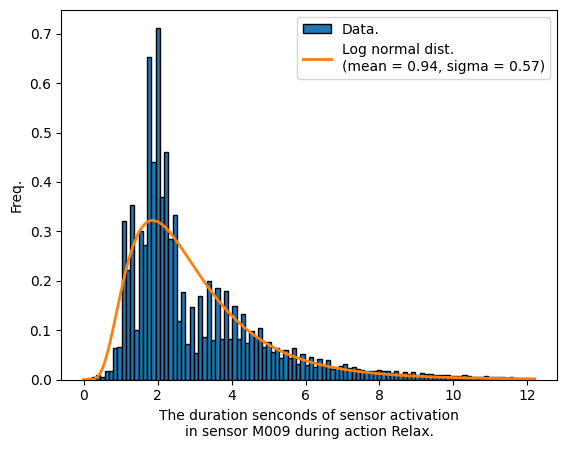

1232 points are removed.


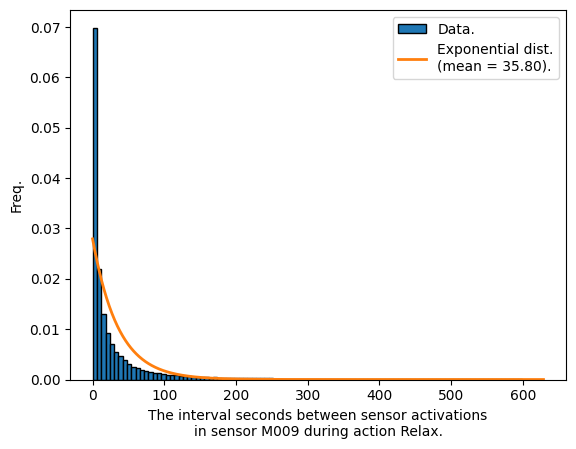

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, expon, lognorm

def draw_histogram_with_exponential_dist(numbers, x_label, save_title):
    plt.hist(numbers, bins=100, edgecolor='black', density=True, label = "Data.")
    xmin, xmax = plt.xlim()
    x = np.linspace(0, xmax, 1000)
    mean = np.mean(np.array(numbers))
    expon_data = expon.pdf(x, scale = mean)  # scale = 1/lambda
    plt.plot(x, expon_data, 'tab:orange', linewidth=2, label = f"Exponential dist.\n(mean = {mean:.2f}).")
    plt.xlabel(x_label)
    plt.ylabel('Freq.')
    plt.legend()
    plt.savefig(save_title, bbox_inches="tight")
    plt.show()
    plt.close()


def draw_histogram_with_log_norm_dist(numbers, x_label, save_title):
    plt.hist(numbers, bins=100, edgecolor='black', density=True, label = "Data.")
    xmin, xmax = plt.xlim()
    x = np.linspace(0, xmax, 1000)
    log_numbers = np.log(np.array(numbers))

    # Parameters for the lognormal distribution
    mean = np.mean(log_numbers)  # Mean on the log scale
    sigma = np.std(log_numbers)  # Standard deviation on the log scale

    # mu, std = norm.fit(numbers)
    log_norm_data = lognorm.pdf(x, s=sigma, scale=np.exp(mean))
    plt.plot(x, log_norm_data, 'tab:orange', linewidth=2, label = f"Log normal dist.\n(mean = {mean:.2f}, sigma = {sigma:.2f})")
    plt.xlabel(x_label)
    plt.ylabel('Freq.')
    plt.legend()
    plt.savefig(save_title, bbox_inches="tight")
    plt.show()
    plt.close()

def delete_outlier_value(data, method = "z-score"):
    _len = len(data)
    if method == "quantile":
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        ret = [x for x in data if lower_bound <= x <= upper_bound]
        print(f"{_len - len(ret)} points are removed.")
        return ret
    elif method == "z-score":
        data = np.array(data)
        z_scores = (data - np.mean(data)) / np.std(data)
        ret = data[(z_scores > -3) & (z_scores < 3)]
        print(f"{_len - ret.shape[0]} points are removed.")
        return ret
    else:
        raise ValueError("method {method} is not defined.")

activity = "Relax"
sensor = "M009"

status = "ON to OFF"
key = (activity, sensor, status)
numbers = duration_dict[key]
numbers = delete_outlier_value(numbers)
x_label = f"The duration senconds of sensor activation\nin sensor {sensor} during action {activity}."
save_title = f"{activity}_{sensor}_{status}.png"
draw_histogram_with_log_norm_dist(numbers, x_label, save_title)

status = "OFF to ON"
key = (activity, sensor, status)
numbers = duration_dict[key]
numbers = delete_outlier_value(numbers)
x_label = f"The interval seconds between sensor activations\nin sensor {sensor} during action {activity}."
save_title = f"{activity}_{sensor}_{status}.png"
draw_histogram_with_exponential_dist(numbers, x_label, save_title)
